# 8. Gaussian Classifiers for Digits and Spam

## 1

In [2]:
import os
import sys
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import scipy.io as sio
import matplotlib.pyplot as plt
import cv2
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from natsort import natsorted
from tqdm.notebook import tqdm

from save_csv import results_to_csv

SEED = 289

In [3]:
def load_data(path):
    data = sio.loadmat(path)
    return data['training_data'], data['test_data'], data['training_labels'].reshape(-1,)

In [4]:
# load data
data_name = 'mnist'
data_path = Path(f'../data/{data_name}_data.mat')
x_train, x_test, y_train = load_data(data_path)

In [5]:
# normalize pixel
x_train = x_train / 255 
x_test = x_test / 255

In [6]:
# fit Gaussian
def fit_gaussian(x_train, y_train):
    labels = np.sort(np.unique(y_train))
    n_labels = len(labels)
    n_features = x_train.shape[1]

    mus = np.zeros((n_labels, n_features))
    sigmas = np.zeros((n_labels, n_features, n_features))

    for i in labels:
        ind_i = np.where(y_train == i)
        x_train_i = x_train[ind_i]
        mus[i, :] = np.mean(x_train_i, axis=0)
        sigmas[i, :, :] = np.cov(x_train_i.T)
        
    return labels, mus, sigmas

In [7]:
labels, mus, sigmas = fit_gaussian(x_train, y_train)

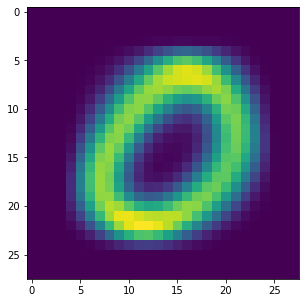

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(mus[0].reshape(28, 28))

## 2

Diagonal terms show larger covariance than off-diagonal terms. It means values at one pixel location across pictures with the same label are more correlated, while values between one pixel location and the another location are less correlated.

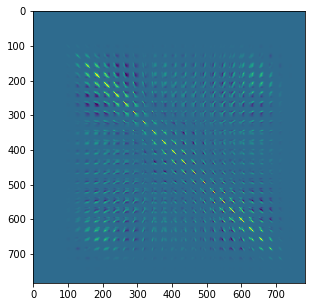

In [9]:
# class 0
fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(sigmas[5])

## 3

### 3 (a)

In [10]:
def tr_va_split(x_train, y_train, n_va, shuffle=False):
    """
    return index of train and validation data
    """
    n_samples = x_train.shape[0]
    n_va = int(n_va)
    if n_va < 1:
        n_va = int(n_samples * n_va)  # from proportion to absolute number

    if shuffle:
        ind_all = np.random.permutation(n_samples)  # shuffle index
    else:
        ind_all = np.arange(n_samples)  # not shuffle index
            
    tr_ind = ind_all[n_va:]
    va_ind = ind_all[:n_va]

    return x_train[tr_ind], x_train[va_ind], y_train[tr_ind], y_train[va_ind]

In [11]:
np.random.seed(SEED)
x_tr, x_va, y_tr, y_va = tr_va_split(x_train, y_train, n_va=1e4, shuffle=True)

In [12]:
class LDA():
    
    def __init__(self):
        pass
    
    def fit(self, x, y):
        # measn and covariance matrixs
        self.labels, self.mus, sigmas = fit_gaussian(x, y)
        self.sigma = sigmas.mean(axis=0)
        
        # priors
        counter = Counter(y_train)
        values = np.array([counter[k] for k in sorted(counter.keys())])
        self.priors = values / len(y_train)
        
    def predict(self, x):
        posts = np.zeros((len(self.labels), x.shape[0]))
        
        # posteriors
        for i, (label, mu, prior) in enumerate(zip(self.labels, self.mus, self.priors)):
            mvn = stats.multivariate_normal(mu, self.sigma, allow_singular=True)
            post = mvn.logpdf(x) + np.log(prior)
            posts[i, :] = post
        
        # pick max post as predict
        preds = np.argmax(posts, axis=0)
        
        return preds

In [13]:
def get_error_rate(y_true, y_pred):
    return 1 - np.mean(y_true == y_pred)

In [14]:
def get_accs(n_trs, model, x_tr, y_tr, x_va, y_va, by_class=False):
    scores = defaultdict(list)

    for n_tr in tqdm(n_trs):
        if model == 'lda':
            model = LDA()
        elif model == 'qda':
            model = QDA()
            
        model.fit(x_tr[:n_tr], y_tr[:n_tr])
        y_pr = model.predict(x_va)
        
        if by_class:
            for c in np.unique(y_va):
                c_ind = np.where(y_va == c)
                acc = get_error_rate(y_va[c_ind], y_pr[c_ind])
                scores['n_tr'].append(n_tr)
                scores['acc'].append(acc)
                scores['class'].append(c)
        else:
            acc = get_error_rate(y_va, y_pr)
            scores['n_tr'].append(n_tr)
            scores['acc'].append(acc)
        
    return scores, model

In [15]:
def plot_accs(scores, label, fig=None, ax=None):
    scores_df = pd.DataFrame(scores)

    if fig is None:
        fig, ax = plt.subplots(figsize=(6,4))
    
    if 'class' not in list(scores.keys()):
        scores_df.plot.line('n_tr', 'acc', marker='x', ax=ax, label=label)
    else:
        for c, gr in scores_df.groupby('class'):
            gr.plot.line('n_tr', 'acc', marker='x', ax=ax, label=f'{label}_{c}')
    
    ax.set_xlabel('train size')
    ax.set_ylabel('error_rate')
    ax.set_ylim(0,1)
    ax.set_xscale('log')
    
    return fig, ax

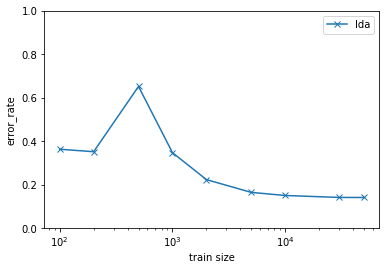

In [16]:
n_trs = np.array([1e2, 2e2, 5e2, 1e3, 2e3, 5e3, 1e4, 3e4, 5e4]).astype(int)
scores_lda, model = get_accs(n_trs, 'lda', x_tr, y_tr, x_va, y_va)
fig, ax = plot_accs(scores_lda, 'lda')

### 3 (b)

In [17]:
class QDA():
    
    def __init__(self):
        pass
    
    def fit(self, x, y):
        # measn and covariance matrixs
        self.labels, self.mus, self.sigmas = fit_gaussian(x, y)
        
        # priors
        counter = Counter(y_train)
        values = np.array([counter[k] for k in sorted(counter.keys())])
        self.priors = values / len(y_train)
        
    def predict(self, x):
        posts = np.zeros((len(self.labels), x.shape[0]))
        
        # posteriors
        for i, (label, mu, sigma, prior) in enumerate(zip(self.labels, self.mus, self.sigmas, self.priors)):
            mvn = stats.multivariate_normal(mu, sigma, allow_singular=True)
            post = mvn.logpdf(x) + np.log(prior)
            posts[i, :] = post
        
        # pick max post as predict
        preds = np.argmax(posts, axis=0)        
        
        return preds

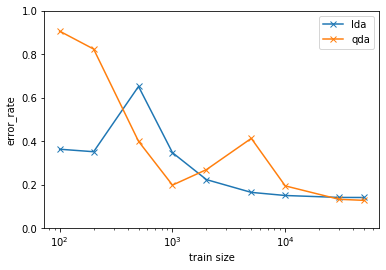

In [18]:
scores_qda, model = get_accs(n_trs, 'qda', x_tr, y_tr, x_va, y_va)
fig, ax = plot_accs(scores_lda, 'lda')
fig, ax = plot_accs(scores_qda, 'qda', fig=fig, ax=ax)

### 3 (c)

LDA peforms better than QDA in many train sizes. I guess this is because the variance and covariance of pixel values is not so different across all classes (digits).

### 3 (d)

Kaggle Name: Takuma Kinoshita  
Score: 0.97220

Pre-process: HOG (Histograms of Oriented Gradients)

In [19]:
class ImagePreprocessor():
    
    def __init__(self, win_size=None, block_size=None, block_stride=None, cell_size=None, nbins=None):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.nbins = nbins

    def transform(self, x_train, x_test):
        # hog features
        pix = self.win_size[0]
        x_train = x_train.reshape((x_train.shape[0], pix, pix, -1))
        x_test = x_test.reshape((x_test.shape[0], pix, pix, -1))

        x_train = self.hog_transform(x_train)
        x_test = self.hog_transform(x_test)

        # flatten
        x_train = x_train.reshape((x_train.shape[0], -1))
        x_test = x_test.reshape((x_test.shape[0], -1))

        return x_train, x_test

    def hog_transform(self, imgs):
        hog = cv2.HOGDescriptor(self.win_size, self.block_size, self.block_stride,
                                self.cell_size, self.nbins)
        features = []
        for img in imgs:
            features.append(hog.compute(img))
        return np.array(features)

In [20]:
np.random.seed(SEED)

# load data
data_name = 'mnist'
data_path = Path(f'../data/{data_name}_data.mat')
x_train, x_test, y_train = load_data(data_path)

# preprocess
preprocessor = ImagePreprocessor(win_size=(28, 28), block_size=(8, 8),
    block_stride=(4, 4), cell_size=(8, 8), nbins=9)
x_train, x_test = preprocessor.transform(x_train, x_test)

# split
x_tr, x_va, y_tr, y_va = tr_va_split(x_train, y_train, n_va=1e4, shuffle=True)

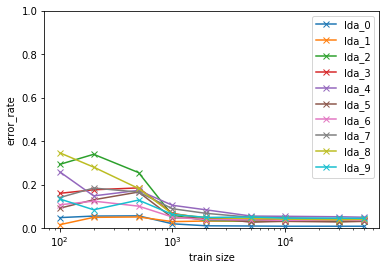

In [21]:
scores_lda, model_lda = get_accs(n_trs, 'lda', x_tr, y_tr, x_va, y_va, by_class=True)
fig, ax = plot_accs(scores_lda, label='lda')

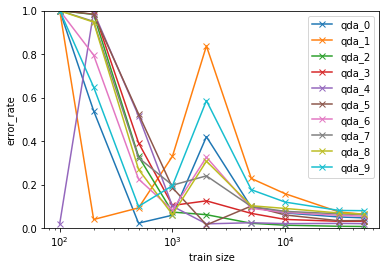

In [22]:
scores_qda, model_qda = get_accs(n_trs, 'qda', x_tr, y_tr, x_va, y_va, by_class=True)
fig, ax = plot_accs(scores_qda, label='qda')

0 is easiest to classify for LDA in the larget training size. On the other hand, 2 is easiest for QDA.

In [23]:
model_lda = LDA()
model_lda.fit(x_tr, y_tr)
y_pr = model_lda.predict(x_va)
get_error_rate(y_va, y_pr)

0.034599999999999964

In [24]:
model_lda = LDA()
model_lda.fit(x_train, y_train)
y_pred = model_lda.predict(x_test)
results_to_csv(y_pred)

## 4

Kaggle Name: Takuma Kinoshita  
Score:

Pre-process: TF-IDF (Term Frequency - Inverse Document Frequency)

In [117]:
def parse_txt(dir_names, data_path):
    texts = defaultdict(list)
    n_samples = {}
    
    for dir_name in dir_names:
        paths = list(Path(data_path, dir_name).glob('*.txt'))
        if dir_name == 'test':
            paths = [Path(data_path, dir_name, str(x) + '.txt') for x in range(len(paths))]
        n_samples[dir_name] = len(paths)
        for txt_path in tqdm(paths):
            with open(txt_path, 'r', encoding='utf-8', errors='ignore') as f:
                text = f.read()
                texts[dir_name].append(text)
                
    return texts, n_samples

In [118]:
# parse txt files
data_path = Path('../data')
dir_names = ['ham', 'spam', 'test']
texts, n_samples = parse_txt(dir_names, data_path)

In [119]:
# tf-idf
vectorizer = TfidfVectorizer(stop_words='english', max_features=200)
x_train = vectorizer.fit_transform(texts['ham'] + texts['spam']).todense()
x_test = vectorizer.transform(texts['test']).todense()

In [120]:
# make label
y_train = np.zeros(x_train.shape[0]).astype(int)
y_train[n_samples['ham']:] = 1

In [121]:
# save
mat_dict = {}
mat_dict['training_data'] = x_train
mat_dict['training_labels'] = y_train
mat_dict['test_data'] = x_test
sio.savemat('../data/my_spam_data.mat', mat_dict)

In [122]:
np.random.seed(SEED)

# load data
data_name = 'my_spam'
data_path = Path(f'../data/{data_name}_data.mat')
x_train, x_test, y_train = load_data(data_path)

# split
x_tr, x_va, y_tr, y_va = tr_va_split(x_train, y_train, n_va=1e3, shuffle=True)

In [123]:
# LDA
lda = LDA()
lda.fit(x_tr, y_tr)
y_pr = lda.predict(x_va)
get_error_rate(y_va, y_pr)

0.05500000000000005

In [125]:
lda.fit(x_train, y_train)
y_pred = lda.predict(x_test)
results_to_csv(y_pred)